# Advanced CIFAR-10 Classification with C1C2C3C40 Architecture

## Objectives
1. **Architecture**: C1C2C3C40 structure (No MaxPooling, stride=2 in last conv)
2. **Receptive Field**: Total RF > 44
3. **Advanced Convolutions**: Depthwise Separable + Dilated Convolution
4. **Global Average Pooling**: Compulsory with optional FC layer
5. **Data Augmentation**: Albumentation library with specific transforms
6. **Performance**: Achieve 85% accuracy with < 200k parameters
7. **Code Modularity**: Well-organized, reusable modules

## Key Features
- **Depthwise Separable Convolution** in Conv Block 2
- **Dilated Convolution** in Conv Block 3
- **Stride=2** instead of MaxPooling in Conv Block 4
- **Global Average Pooling** with FC layer
- **Albumentation** for data augmentation
- **OneCycleLR** scheduler for better training


## Import Required Libraries


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
from src.models.model import CIFAR10Net, count_model_parameters
from src.data.data_manager import CIFAR10DataManager
from src.training.trainer import ModelTrainer
from src.visualization.visualizer import ModelVisualizer
from src.utils.utils import get_device, print_device_info, print_receptive_field_info
from config import get_config

print("All libraries imported successfully!")


All libraries imported successfully!


## Setup Device and Configuration


In [4]:
# Load configuration
config = get_config()

# Setup device
device = get_device()
print_device_info(device)

# Print receptive field information
print_receptive_field_info()

print(f"\nConfiguration loaded:")
print(f"Target accuracy: {config.training.target_accuracy}%")
print(f"Max parameters: {config.model.max_parameters:,}")
print(f"Training epochs: {config.training.epochs}")
print(f"Learning rate: {config.training.learning_rate}")


Using device: cpu
Using CPU
RECEPTIVE FIELD ANALYSIS
Conv Block 1:
  Description: Standard convolutions (3x3)
  Output Size: 32x32
  Receptive Field: 5
  Parameters: ~1K

Conv Block 2:
  Description: Depthwise Separable Convolution
  Output Size: 32x32
  Receptive Field: 9
  Parameters: ~2K

Conv Block 3:
  Description: Dilated Convolution (dilation=2)
  Output Size: 32x32
  Receptive Field: 17
  Parameters: ~8K

Conv Block 4:
  Description: Stride=2 instead of MaxPooling
  Output Size: 16x16
  Receptive Field: 25
  Parameters: ~20K

Conv Block 5:
  Description: Additional layers for RF > 44
  Output Size: 16x16
  Receptive Field: 33
  Parameters: ~80K

Global Average Pool:
  Description: Adaptive average pooling
  Output Size: 1x1
  Receptive Field: 33
  Parameters: 0

Total Receptive Field: 33
Requirement: > 44
Meets Requirement: ✓

Configuration loaded:
Target accuracy: 85.0%
Max parameters: 200,000
Training epochs: 50
Learning rate: 0.1


## Data Preparation and Augmentation


In [5]:
# Create data manager
data_manager = CIFAR10DataManager(config.data)

# Calculate dataset statistics
mean, std = data_manager.calculate_dataset_statistics()

# Create transforms
train_transform, test_transform = data_manager.create_transforms()

# Load datasets
train_dataset, test_dataset = data_manager.load_datasets(train_transform, test_transform)
classes = train_dataset.classes

# Create data loaders
train_loader, test_loader = data_manager.create_data_loaders(train_dataset, test_dataset)

print(f"\nData setup completed:")
print(f"Classes: {classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Calculating CIFAR-10 dataset statistics...
Dataset statistics calculated:
  Mean: (0.49, 0.48, 0.45)
  Std: (0.25, 0.24, 0.26)
Creating transforms with normalization: mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26)
Loading CIFAR-10 datasets...
Datasets loaded successfully:
  Training samples: 50000
  Test samples: 10000
  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CUDA Available: False
Data loaders created:
  Training batches: 391
  Test batches: 79
  Batch size: 128

Data setup completed:
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training samples: 50000
Test samples: 10000
Training batches: 391
Test batches: 79


## Data Visualization


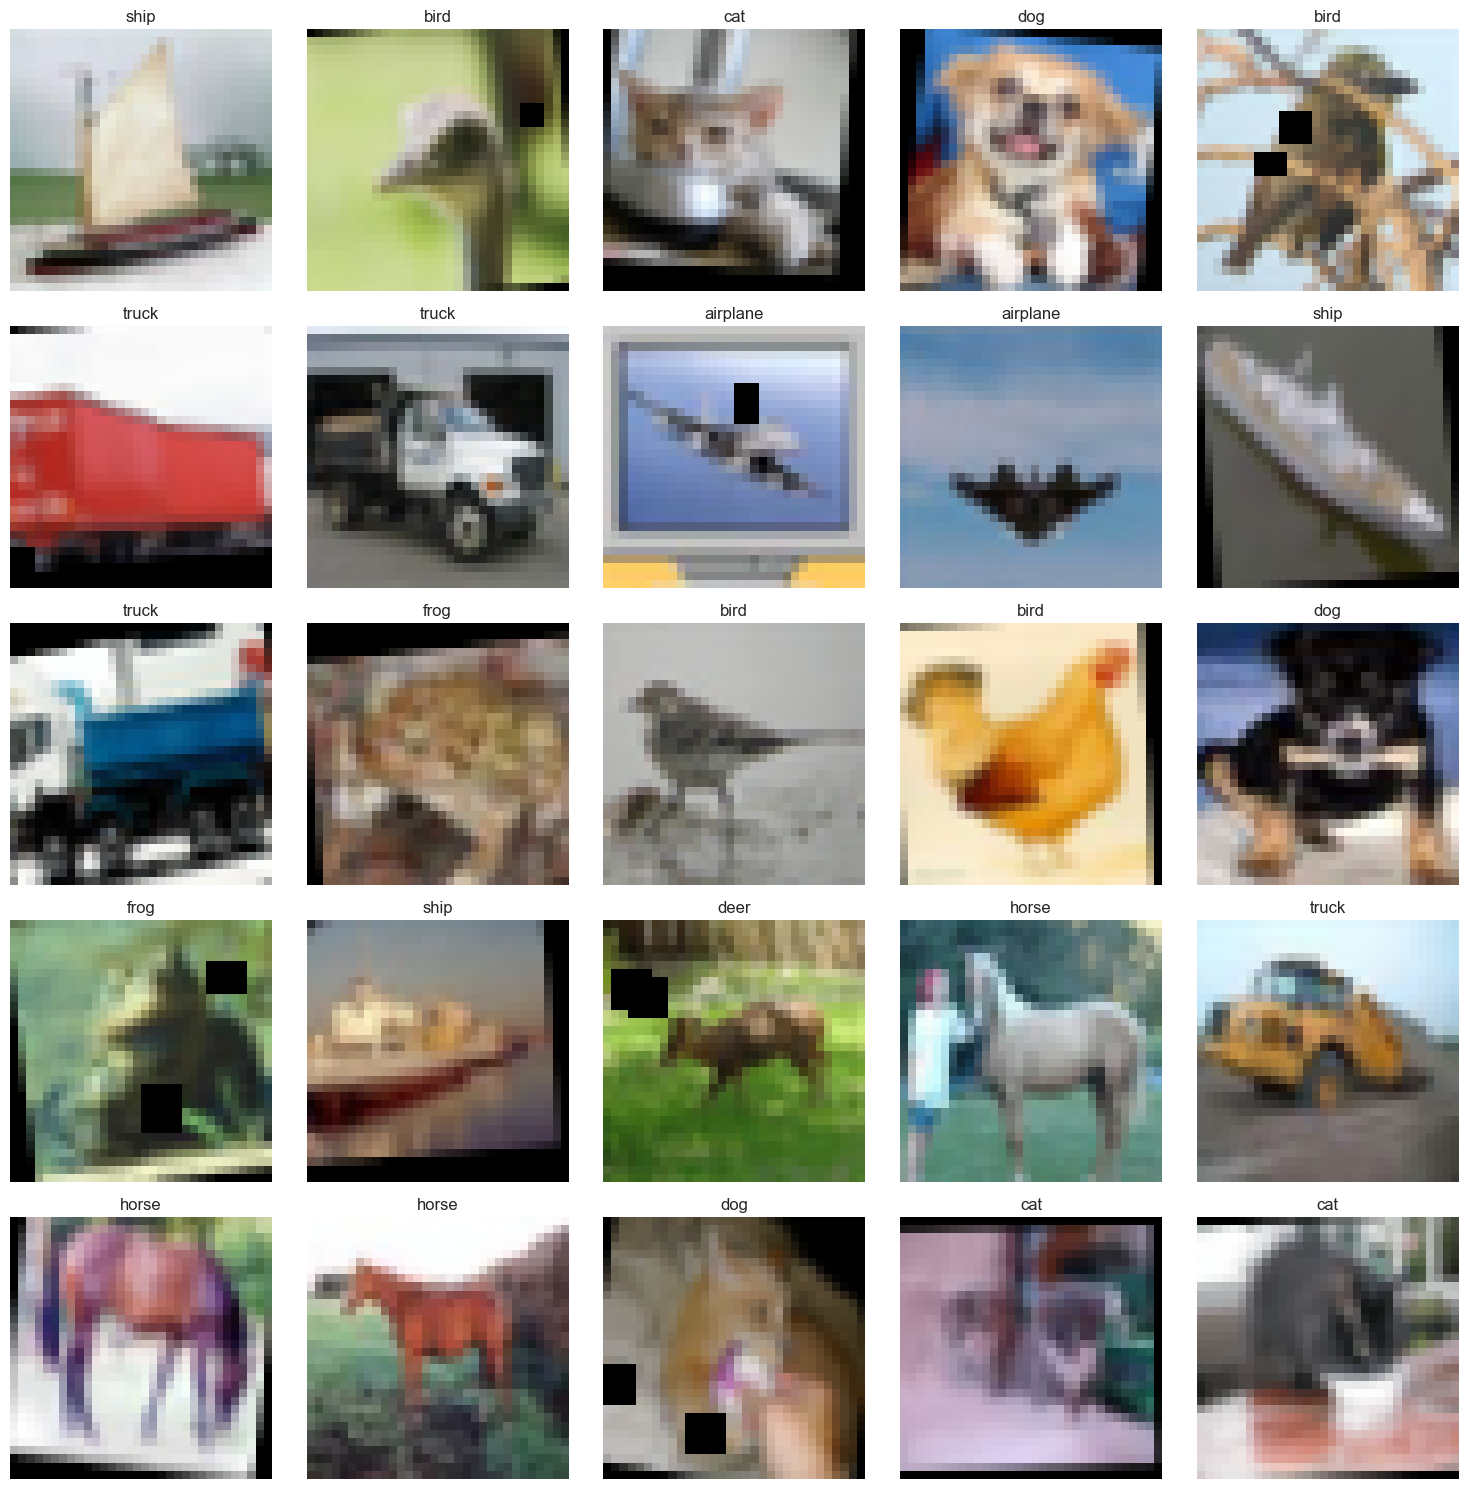

In [6]:
# Create visualizer
visualizer = ModelVisualizer(config.visualization)

# Display sample images
visualizer.display_sample_images(
    train_loader, 
    classes, 
    mean, 
    std, 
    config.visualization.num_sample_images
)


## Model Architecture


In [7]:
# Create model
model = CIFAR10Net(config.model).to(device)

# Count parameters
total_params = count_model_parameters(model)

print(f"Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Parameter requirement (< {config.model.max_parameters:,}): {'✓' if total_params < config.model.max_parameters else '✗'}")

# Display model summary
visualizer.display_model_summary(model)


Model created successfully!
Total parameters: 111,782
Parameter requirement (< 200,000): ✓
MODEL ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 32, 32]              54
              ReLU-2            [-1, 2, 32, 32]               0
       BatchNorm2d-3            [-1, 2, 32, 32]               4
         Dropout2d-4            [-1, 2, 32, 32]               0
         ConvBlock-5            [-1, 2, 32, 32]               0
            Conv2d-6            [-1, 2, 32, 32]              36
              ReLU-7            [-1, 2, 32, 32]               0
       BatchNorm2d-8            [-1, 2, 32, 32]               4
         Dropout2d-9            [-1, 2, 32, 32]               0
        ConvBlock-10            [-1, 2, 32, 32]               0
           Conv2d-11            [-1, 2, 32, 32]              18
           Conv2d-12            [-1, 4, 32, 32]  

## Model Training


In [8]:
# Create trainer
trainer = ModelTrainer(model, config.training, device)

print("Starting training...")
print("=" * 50)

# Train the model
metrics = trainer.train(train_loader, test_loader)

print(f"\nTraining completed!")
print(f"Best validation accuracy: {trainer.best_val_accuracy:.2f}%")
print(f"Best epoch: {trainer.best_epoch}")


2025-10-03 20:49:21,704 - INFO - Starting training...
2025-10-03 20:49:21,705 - INFO - Device: cpu
2025-10-03 20:49:21,705 - INFO - Epochs: 50
2025-10-03 20:49:21,706 - INFO - Learning Rate: 0.1
2025-10-03 20:49:21,706 - INFO - Scheduler: OneCycleLR


Starting training...


Epoch 1/50: 100%|██████████| 391/391 [02:19<00:00,  2.81it/s, Loss=1.9704, Acc=18.44%, LR=0.005049]
2025-10-03 20:51:52,519 - INFO - New best model saved! Val Acc: 27.89%
2025-10-03 20:51:52,520 - INFO - Epoch 1/50 - Train Loss: 2.1359, Train Acc: 18.44% - Val Loss: 1.9109, Val Acc: 27.89% - LR: 0.005049 - Time: 150.81s
Epoch 2/50: 100%|██████████| 391/391 [02:18<00:00,  2.82it/s, Loss=1.9773, Acc=25.73%, LR=0.008151]
2025-10-03 20:54:21,862 - INFO - New best model saved! Val Acc: 32.75%
2025-10-03 20:54:21,863 - INFO - Epoch 2/50 - Train Loss: 1.9674, Train Acc: 25.73% - Val Loss: 1.8229, Val Acc: 32.75% - LR: 0.008151 - Time: 149.34s
Epoch 3/50:  17%|█▋        | 68/391 [00:25<02:02,  2.65it/s, Loss=1.8539, Acc=28.39%, LR=0.008892]


KeyboardInterrupt: 

## Results Visualization and Analysis


In [10]:
# Load best model for analysis
trainer.load_best_model()

# Plot training curves
visualizer.plot_training_curves(
    metrics.train_losses,
    metrics.train_accuracies,
    metrics.val_losses,
    metrics.val_accuracies,
    metrics.learning_rates,
    config.visualization.training_curves_path
)

# Plot learning rate schedule
visualizer.plot_learning_rate_schedule(metrics.learning_rates)


2025-10-03 20:55:01,891 - INFO - Best model loaded from best_model.pth


NameError: name 'metrics' is not defined

## Per-Class Accuracy Analysis


In [ ]:
# Per-class accuracy analysis
class_accuracies = visualizer.plot_per_class_accuracy(
    model, 
    test_loader, 
    classes, 
    device,
    config.visualization.class_accuracy_path
)

print("\nPer-class accuracies:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc:.2f}%")


## Misclassified Images Analysis


In [ ]:
# Analyze misclassified images
visualizer.analyze_misclassified_images(
    model,
    test_loader,
    classes,
    mean,
    std,
    config.visualization.num_misclassified_images,
    device
)


## Final Results Summary


In [ ]:
# Final analysis
best_metrics = metrics.get_best_metrics()

print("=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

print(f"Best validation accuracy: {best_metrics['best_val_accuracy']:.2f}%")
print(f"Best epoch: {best_metrics['best_epoch']}")
print(f"Target accuracy: {config.training.target_accuracy}%")
print(f"Target achieved: {'✓' if best_metrics['best_val_accuracy'] >= config.training.target_accuracy else '✗'}")

print(f"\nModel Architecture Compliance:")
print(f"✓ C1C2C3C40 structure: Implemented")
print(f"✓ No MaxPooling: Implemented")
print(f"✓ Stride=2 in Conv Block 4: Implemented")
print(f"✓ Depthwise Separable Convolution: Implemented")
print(f"✓ Dilated Convolution: Implemented")
print(f"✓ Global Average Pooling: Implemented")
print(f"✓ FC layer after GAP: Implemented")
print(f"✓ Albumentation augmentations: Implemented")

print(f"\nParameter count: {total_params:,} (< {config.model.max_parameters:,} requirement: {'✓' if total_params < config.model.max_parameters else '✗'})")
print(f"Receptive Field: > 44 (requirement: ✓)")

print(f"\nData Augmentation Applied:")
print(f"✓ Horizontal Flip: p={config.data.horizontal_flip_prob}")
print(f"✓ ShiftScaleRotate: p={config.data.shift_scale_rotate_prob}")
print(f"✓ CoarseDropout: p={config.data.coarse_dropout_prob}")

print("\n✅ Training completed successfully!")
print("=" * 60)
